# "Aggregating Data with Pandas"
> "Aggregating previously cleaned 2019 animal rescue data from Cape Cod for summary statistics."

- toc: false
- badges: true
- comments: true
- author: Antonio Jurlina
- categories: [learning, python]

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import os

First, we start by importing the two data sets to be merged. The *data* DataFrame is the same one that was cleaned in the previous lab. The *zipcodes* DataFrame will be used to fill in all the missing values in the *data* DataFrame.

In [3]:
os.chdir('/Users/antoniojurlina/Projects/learning_python/data/')

data=pd.read_csv('CapeCodCases2019_clean.csv')
zipcodes = pd.read_csv('MassachusettsZipcodeData.csv')

data['city'] = data['city'].str.replace("Yarmouthport", "Yarmouth Port")

zipcodes['city_town'] = zipcodes['city_town'].str.replace(", TOWN OF", "").str.title()
zipcodes['county'] = zipcodes['county'].str.title()
zipcodes['pc_name'] = zipcodes['pc_name'].str.title()
zipcodes['postcode'] = zipcodes['postcode'].astype(str)

zipcodes_short = zipcodes[['postcode', 'city_town', 'county']]. \
                    rename(columns = {'postcode':'zip_code','city_town':'city'})

The cleaned data:

In [4]:
data.head()

,Unnamed: 0,address,city,common_name,county,date,disposition,keywords,admission_id,case_year,zip_code
0,0,Long Beach,Hyannis,Common Eider,Barnstable,2019-01-01,Died +24hr,NaN,1,2019,2601
1,1,3260 Main Street,Brewster,Common Eider,Barnstable,2019-01-02,Euthanized +24hr,NaN,2,2019,2671
2,2,Thumpertown Beach,Eastham,Razorbill,Barnstable,2019-01-02,Dead on arrival,NaN,3,2019,NaN
3,3,5575 State Highway,Eastham,Southern Flying Squirrel,Barnstable,2019-01-03,Released,NaN,4,2019,2651
4,4,5575 State Highway,Eastham,Southern Flying Squirrel,Barnstable,2019-01-03,Released,NaN,5,2019,2651


The data to be used for replacing missing values:

In [5]:
zipcodes_short.head()

,zip_code,city,county
0,1331,Athol,Worcester
1,2769,Rehoboth,Bristol
2,1085,Westfield,Hampden
3,1370,Shelburne,Franklin
4,1235,Hinsdale,Berkshire


Here we merge the two data frames, fill the missing values and retrieve the relevant columns.

In [6]:
merged_data = data.merge(zipcodes_short, on=['city'], how='left')

county_na_before  = merged_data['county_x'].isna().sum()
zipcode_na_before = merged_data['zip_code_x'].isna().sum()

merged_data['county_x'] = merged_data['county_x'].fillna(merged_data['county_y'])
merged_data['zip_code_x'] = merged_data['zip_code_x'].fillna(merged_data['zip_code_y'])

county_na_after  = merged_data['county_x'].isna().sum()
zipcode_na_after = merged_data['zip_code_x'].isna().sum()

clean_data = merged_data[['address', 'city', 'common_name', 'county_x', 'date', 'disposition', 'zip_code_x']]
clean_data = clean_data.drop_duplicates(subset=clean_data.columns.difference(['zip_code_x'])) \
                       .rename(columns = {'county_x':'county', 'zip_code_x':'zipcode'})
clean_data.head()

,address,city,common_name,county,date,disposition,zipcode
0,Long Beach,Hyannis,Common Eider,Barnstable,2019-01-01,Died +24hr,2601
1,3260 Main Street,Brewster,Common Eider,Barnstable,2019-01-02,Euthanized +24hr,2671
2,Thumpertown Beach,Eastham,Razorbill,Barnstable,2019-01-02,Dead on arrival,2642
3,5575 State Highway,Eastham,Southern Flying Squirrel,Barnstable,2019-01-03,Released,2651
8,Nickerson State Park,Brewster,Common Loon,Barnstable,2019-01-03,Died +24hr,2631


In [7]:
print('The number of missing values in the county column decreased from', county_na_before, 'to' , county_na_after)

The number of missing values in the county column decreased from 151 to 13


In [8]:
print('The number of missing values in the zipcode column decreased from', zipcode_na_before, 'to' , zipcode_na_after)

The number of missing values in the zipcode column decreased from 1415 to 133


Using combinations of the **common name** field with **city** to group and summarize the 10 most common types of animal that have been rescued by city:

In [9]:
view = clean_data.groupby(['city', 'common_name']).size().reset_index(name = 'count'). \
    sort_values(['city', 'count'], ascending=False).groupby('city').head(10).reset_index(drop=True)

view

,city,common_name,count
0,Yarmouth Port,Chimney Swift,2
1,Yarmouth Port,Downy Woodpecker,2
2,Yarmouth Port,Black-Capped Chickadee,1
3,Yarmouth Port,Eastern Cottontail,1
4,Yarmouth Port,Eastern Gray Squirrel,1
...,...,...,...
377,Barnstable,American Robin,1
378,Barnstable,House Sparrow,1
379,Barnstable,Mourning Dove,1
380,Athol,American Robin,1


Reporting and creating bar charts of the top 10 animals (Common Name) by city that have been rescued.

**Note:** *Faceting over all the cities in the data set renders any data visualization unusable. Furthermore, many cities had only 1 or 2 animals rescued over the entire recorded period. Therefore, bar charts were reported separately for each city, and only when 3 or more distinct species had been rescued.*

/Users/antoniojurlina/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


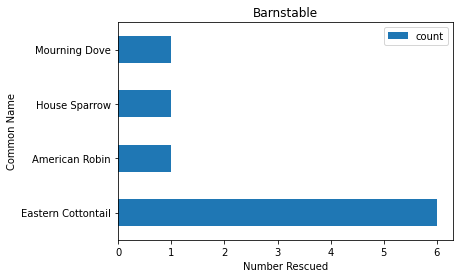

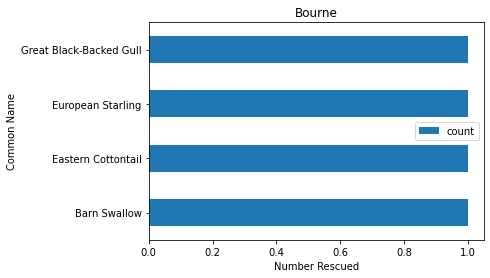

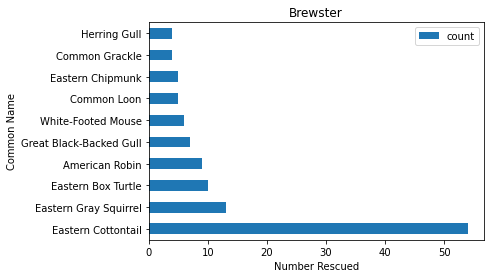

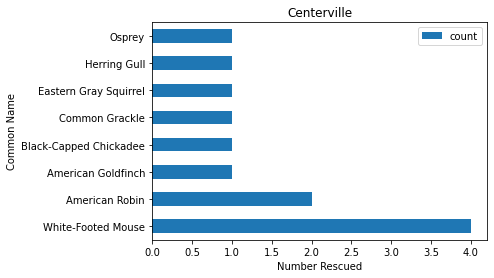

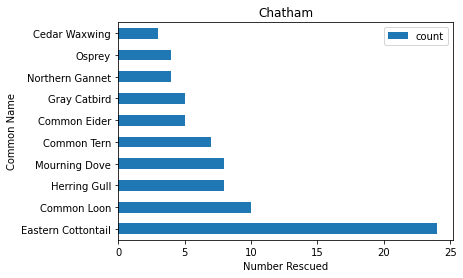

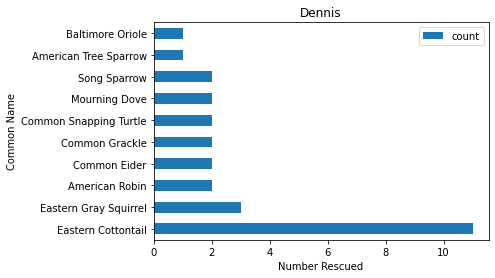

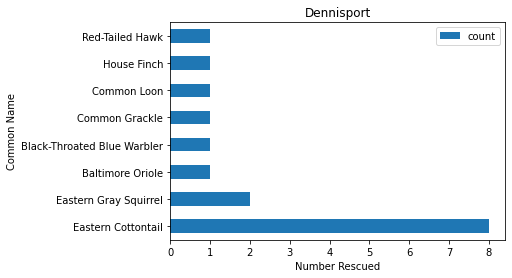

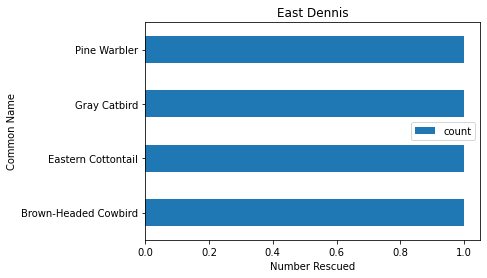

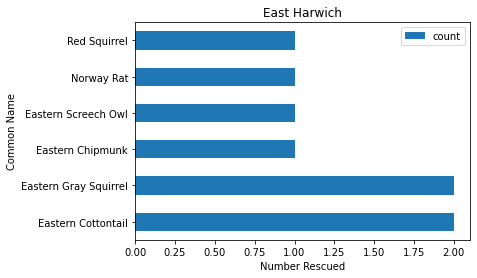

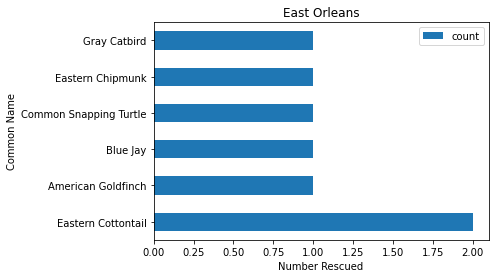

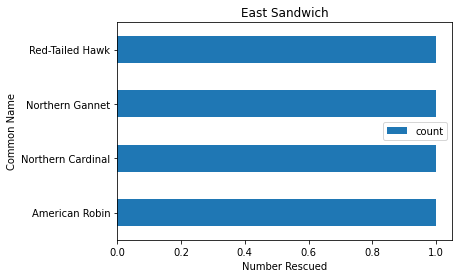

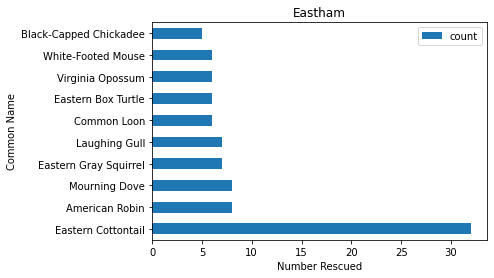

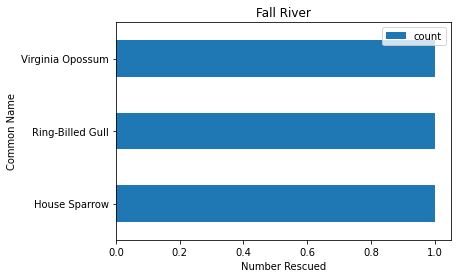

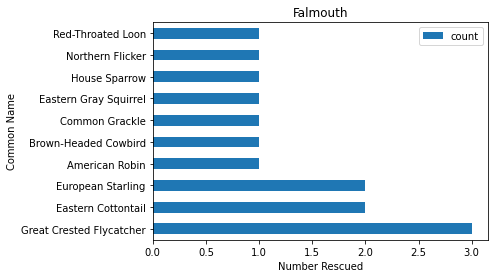

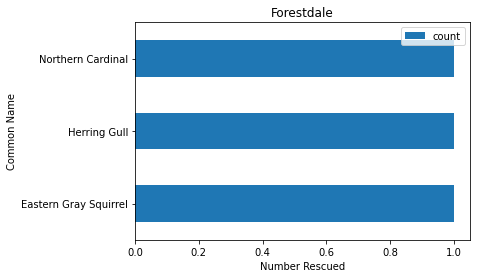

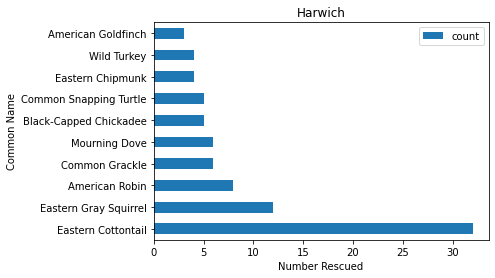

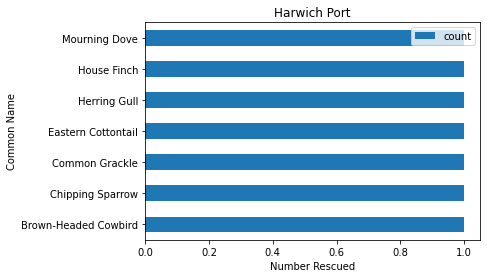

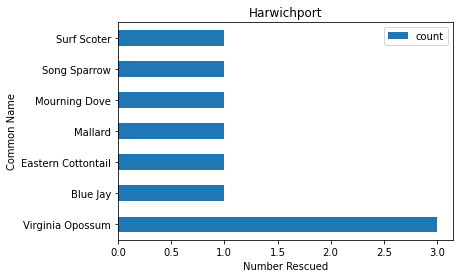

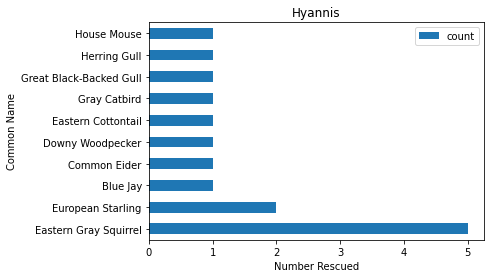

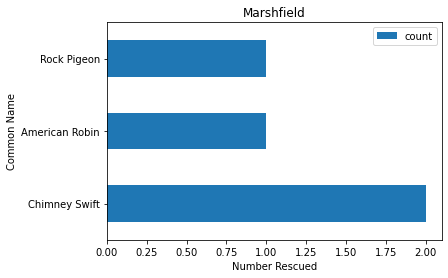

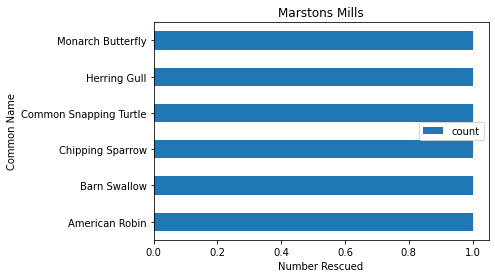

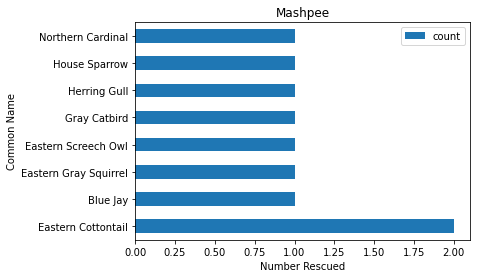

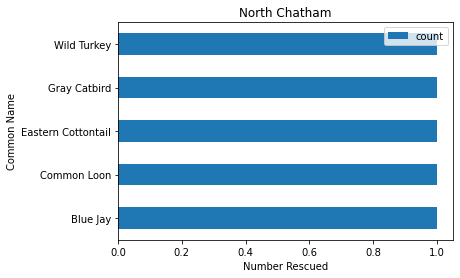

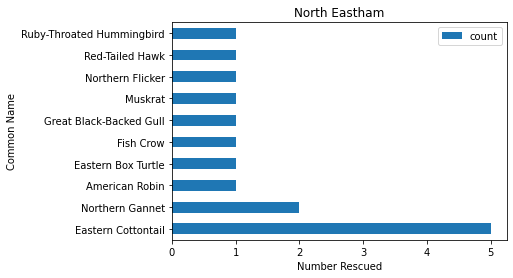

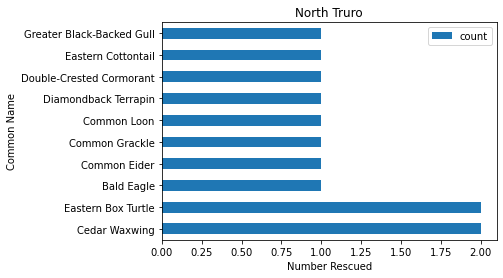

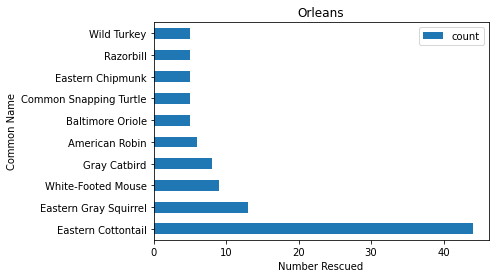

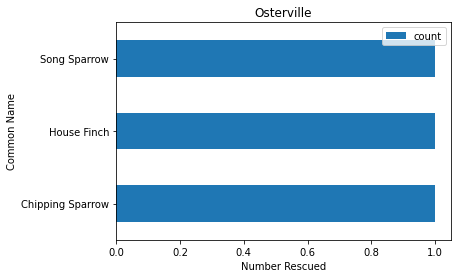

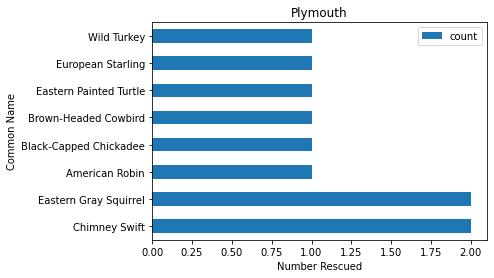

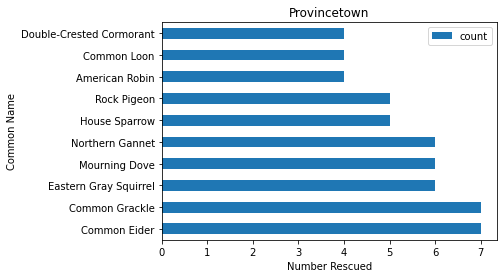

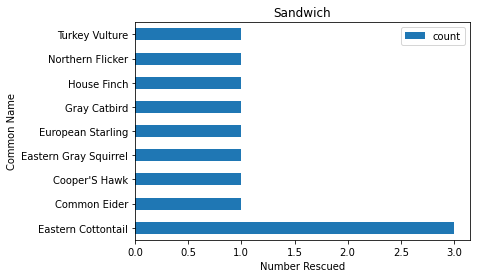

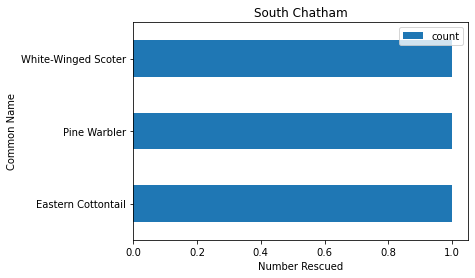

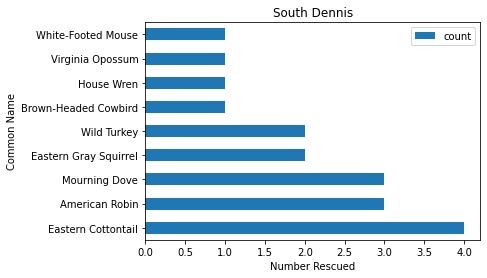

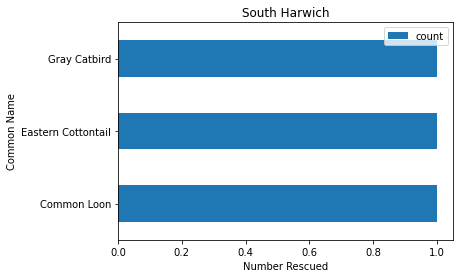

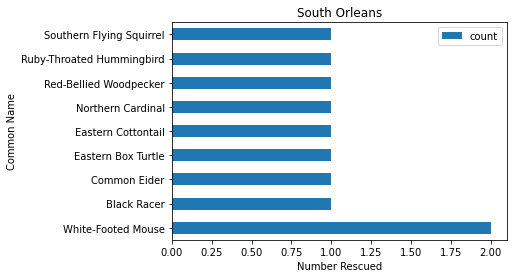

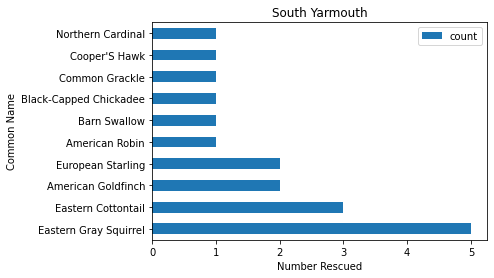

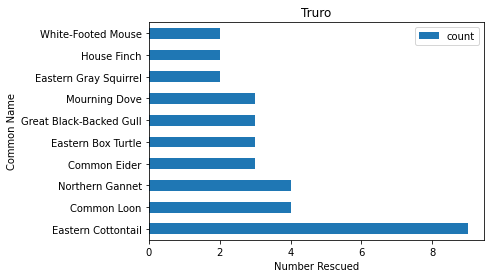

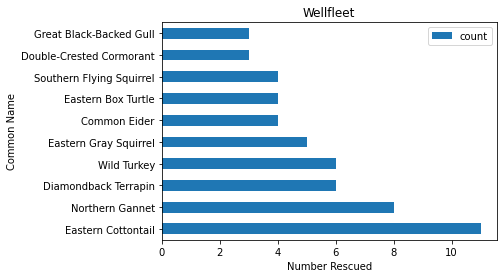

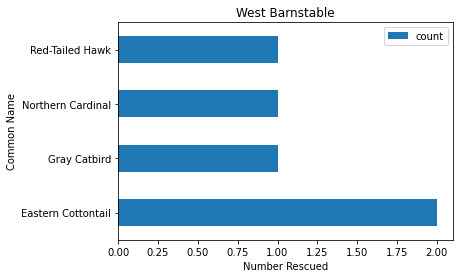

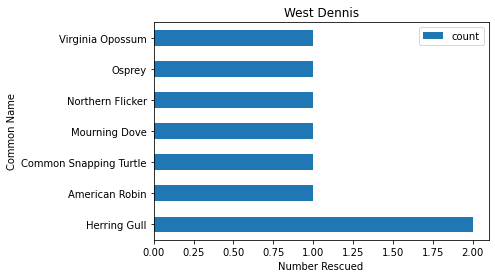

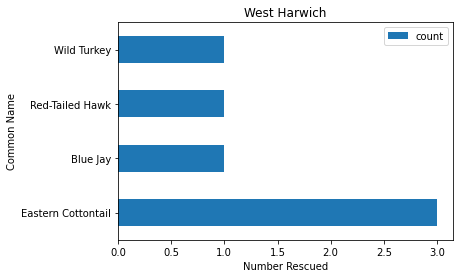

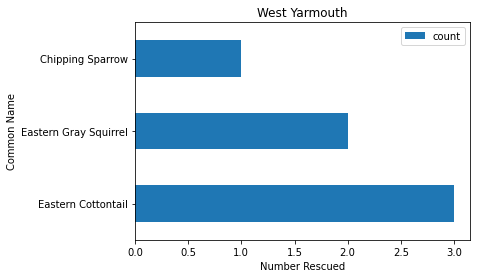

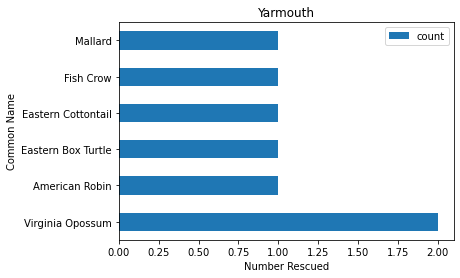

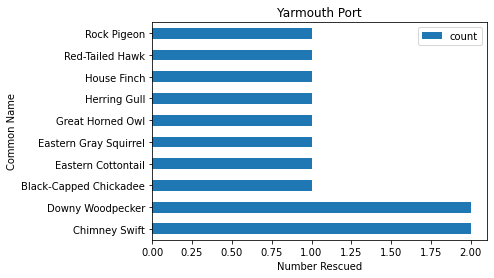

In [10]:
filtered = view.groupby('city').size().reset_index(name='n_of_species')
cities = filtered[filtered['n_of_species'] > 2]['city'].unique()

for x in cities:
  view[view['city']==x].drop('city', axis=1).set_index('common_name').plot(kind='barh')
  plt.title(x)
  plt.ylabel("Common Name")
  plt.xlabel("Number Rescued")

For the data and other notebooks, see [github.com/antoniojurlina/learning_python](https://github.com/antoniojurlina/learning_python).